In [767]:
import numpy as np
import pandas as pd
import random as ran
import datetime as dt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt

In [768]:
class User:
    def __init__(self, user_id,importance_features, not_sincerity=False):
        self.user_id = user_id
        self.importance_features = importance_features
        self.survey = pd.DataFrame(columns=['no','temp','hum', 'lux', 'score'])
        self.not_sincerity = not_sincerity
        
    def save_survey(self, no,temp, hum, lux ,score):
        self.survey = self.survey.append({
            "no": no,
            "temp": temp,
            "hum": hum,
            "lux": lux,
            "score": score
        }, ignore_index=True)
    
    def score(self, temp, hum, lux):
        _score = np.array([0,0,0])
        
        if len(self.importance_features) == 0:
            if self.not_sincerity:
                for idx in range(0, len(_score)):
                    _score[idx] = 20
            else:
                one_line = ran.randrange(0, 2)
                if one_line == 0:
                    s = ran.randrange(5, 20, 5)
                    for idx in range(0, len(_score)):
                        _score[idx] = s
                else:
                    for idx in range(0, len(_score)):
                        _score[idx] = ran.randrange(5, 20)
        else:
            if 'temp' in self.importance_features:
                if (temp >= 18) & (temp <= 20):
                    _score[0] = 20
                else:
                    err = 0
                    if temp <= 18:
                        err = 18 - temp
                    else:
                        err = temp - 20
                    _score[0] = 20 - round(err / 2)
            else:
                _score[0] = ran.randrange(15, 20)
            
            if 'hum' in self.importance_features:
                if (hum >= 40) & (hum <= 60):
                    _score[1] = 20
                else:
                    err = 0
                    if hum <= 40:
                        err = 40 - hum
                    else:
                        err = hum - 60
                    _score[1] = 20 - round(err / 5)
            else:
                _score[1] = ran.randrange(15, 20)


            if 'lux' in self.importance_features:
                if (lux >= 700) & (lux <= 1500):
                    _score[2] = 20
                else:
                    err = 0
                    if lux < 700:
                        err = 700 - lux
                    else:
                        err = lux - 1500
                    _score[2] = 20 - round(err / 100)
            else:
                _score[2] = ran.randrange(15, 20)

        return _score.sum()
    
def generate_features():
    features = ['temp', 'hum', 'lux']
    imp_features = list()
    for f in features:
        is_in = ran.randrange(0,2)
        if is_in == 0:
            imp_features.append(f)
    
    if len(imp_features) == 0:
        is_in = ran.randrange(0, 3)
        imp_features.append(features[is_in])
        
    return imp_features            

In [769]:
# 성실 참여자 50명 생성
users = list()
for user_id in range(0, 50):
    user = User(user_id, generate_features())
    users.append(user)
    
# 불성실 참여자 30명 생성
for user_id in range(50, 80):
    user = User(user_id, [])
    users.append(user)
    
# 매우불성실 참여자 20명 생성
for user_id in range(80, 100):
    user = User(user_id, [], True)
    users.append(user)
    
now = dt.datetime.now()

for days in range(0, 540):
    now_after = now + dt.timedelta(days=days)
    str_after = dt.datetime.strftime(now_after, '%Y-%m-%d')
    
    # 온도 10~32
    ran_temp = ran.randrange(10, 33)
    
    # 습도 30 ~ 80
    ran_hum = ran.randrange(30, 81)
    
    # 조도 200 ~ 1900 (100 단위)
    ran_lux = ran.randrange(200, 1901, 100)
    
    for user in users:
        _s = user.score(ran_temp,
                       ran_hum,
                       ran_lux)
        user.save_survey(
            days,
            ran_temp,
            ran_hum,
            ran_lux,
            _s
        )

In [770]:
max_temp = users[0].survey['temp'].max()
max_hum = users[0].survey['hum'].max()
max_lux = users[0].survey['lux'].max()

# 정규화
norm_no = users[0].survey['no'] / users[0].survey['no'].max()
norm_temp = users[0].survey['temp'] / max_temp
norm_hum = users[0].survey['hum'] / max_hum
norm_lux = users[0].survey['lux'] / max_lux

for idx in range(0, 100):
        users[idx].survey['no'] = norm_no
        users[idx].survey['temp'] = norm_temp
        users[idx].survey['hum'] = norm_hum
        users[idx].survey['lux'] = norm_lux

In [771]:
# features = np.array(['no', 'temp', 'hum', 'lux'])
features = np.array(['temp', 'hum', 'lux'])
_record = pd.DataFrame(columns=['user id',
                                'imp features', 
                                'RF imp features', 
                                'mse'])
models = np.array([])

for user in users:
    df = user.survey
    X = df[features].to_numpy().copy()
    y = df[['score']].to_numpy().copy()
    RF_imp_features = None
    
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2)

    RFModel = RandomForestRegressor(n_estimators=100,
                                    max_features=3,
                                oob_score=False,random_state=531)
    RFModel.fit(X_train, y_train.ravel())
    models = np.append(models, RFModel)
    prediction = RFModel.predict(X_test)
    
    mse = mean_squared_error(y_test,prediction)
    
    feature_importance = RFModel.feature_importances_
    if len(set(feature_importance)) == 1:
        RF_imp_features = []
    else:
        feature_importance = feature_importance / feature_importance.max()
    
    sorted_idx = np.argsort(feature_importance)
    bar_pos = np.arange(sorted_idx.shape[0]) + .5
    
    _features = features[sorted_idx][::-1]
    user_id = user.user_id
    user_imp_features = user.importance_features
    
    imp_length = len(user_imp_features)
    
    if RF_imp_features == None:
        if imp_length == 0:
            RF_imp_features = [_features[0]]
        else:
            RF_imp_features = _features[:imp_length]
        
    _imp_features = RF_imp_features
    imp_features = list()
    
    for _ in ['no', 'temp', 'hum', 'lux']:
        if _ in _imp_features:
            imp_features.append(_)

    _record = _record.append({
        "user id": user_id,
        "mse": mse,
        "imp features": ",".join(user_imp_features),
        "RF imp features": ",".join(imp_features)
    }, ignore_index=True)

In [772]:
part_user = _record[:50].copy()

_analysis = pd.DataFrame(columns=['총 참여자 수','중요 특징 비교', '평균 mse'])

user_cnt = len(part_user)
compare_cnt = part_user[part_user['imp features'] == part_user['RF imp features']].count()['imp features']
mean_mse = part_user[part_user['imp features'] == part_user['RF imp features']]['mse'].mean()

_analysis = _analysis.append({
    "총 참여자 수": str(user_cnt),
    "중요 특징 비교": str(compare_cnt),
    "평균 mse": mean_mse
}, ignore_index=True)

_analysis

,총 참여자 수,중요 특징 비교,평균 mse
0,50,50,4.088559


In [773]:
unpart_user = _record[50:].copy()

_analysis = pd.DataFrame(columns=['총 참여자 수','중요 특징 비교', '평균 mse'])

user_cnt = len(unpart_user)
compare_cnt = unpart_user[(unpart_user['imp features'] != "") & \
   (unpart_user['imp features'] == unpart_user['RF imp features'])].count()['imp features']
mean_mse = unpart_user[unpart_user['imp features'] == unpart_user['RF imp features']]['mse'].mean()

_analysis = _analysis.append({
    "총 참여자 수": str(user_cnt),
    "중요 특징 비교": str(compare_cnt),
    "평균 mse": mean_mse
}, ignore_index=True)

_analysis

,총 참여자 수,중요 특징 비교,평균 mse
0,50,0,0.0


In [774]:
anal_user = part_user.copy()

anal_user['temp'] = part_user['imp features'].map(lambda x: "temp" in x)
anal_user['hum'] = part_user['imp features'].map(lambda x: "hum" in x)
anal_user['lux'] = part_user['imp features'].map(lambda x: "lux" in x)

apt_anal = pd.DataFrame()
apt_anal['온도'] = [anal_user[anal_user['temp'] == True].count().values[0]]
apt_anal['습도'] = [anal_user[anal_user['hum'] == True].count().values[0]]
apt_anal['조도'] = [anal_user[anal_user['lux'] == True].count().values[0]]

apt_anal

,온도,습도,조도
0,27,22,20


In [775]:
survey_mean = np.array([])
feature_tmp = np.array([])

for _ in users[0].survey.values:
    feature_tmp = np.append(feature_tmp,_[1:4])
feature_tmp = feature_tmp.reshape(-1, 3)

for survey_no in range(0,540):
    _tmp = np.array([])
    for user_no in range(0, 50):
        _tmp = np.append(_tmp, users[user_no].survey.loc[survey_no]['score'])
    survey_mean = np.append(survey_mean,_tmp.mean())

In [776]:
feature_tmp

array([[1.0, 0.95, 0.6842105263157895],
       [0.53125, 0.5625, 0.10526315789473684],
       [0.65625, 0.575, 0.6842105263157895],
       ...,
       [0.6875, 0.7375, 0.8421052631578947],
       [0.40625, 0.9375, 0.5789473684210527],
       [0.40625, 0.8, 0.7368421052631579]], dtype=object)

In [777]:
survey_mean

array([50.62, 53.06, 54.84, 54.16, 52.7 , 51.78, 54.02, 55.26, 51.54,
       51.84, 53.2 , 54.14, 54.74, 53.44, 51.8 , 54.34, 53.76, 54.26,
       55.  , 53.38, 53.4 , 51.82, 52.  , 52.06, 50.76, 52.5 , 53.9 ,
       52.06, 54.6 , 52.78, 52.1 , 53.04, 52.5 , 50.48, 54.9 , 51.92,
       52.84, 51.28, 53.66, 53.56, 51.32, 52.4 , 50.62, 51.04, 55.18,
       49.34, 50.2 , 51.02, 53.18, 53.54, 52.54, 53.08, 52.08, 54.4 ,
       55.62, 52.96, 54.62, 54.54, 50.36, 53.84, 51.5 , 52.08, 53.4 ,
       54.68, 53.78, 51.68, 54.24, 53.9 , 53.54, 53.7 , 53.88, 52.56,
       52.46, 51.7 , 55.  , 53.34, 51.7 , 52.76, 52.46, 50.66, 51.62,
       54.34, 52.72, 48.32, 52.02, 51.74, 52.22, 52.68, 51.72, 51.46,
       50.94, 51.82, 52.94, 52.4 , 53.1 , 54.16, 53.12, 53.3 , 51.92,
       51.38, 54.66, 53.36, 52.54, 55.16, 52.34, 54.76, 55.5 , 51.02,
       53.86, 55.02, 53.1 , 52.82, 52.48, 53.52, 52.48, 52.12, 51.76,
       53.12, 53.42, 51.46, 52.18, 51.24, 53.3 , 52.36, 52.56, 53.34,
       53.42, 53.24,

In [778]:
anal_mean = pd.DataFrame(columns=["실제 설문점수", "예측 설문점수"])
anal_np = np.array([])

for user_idx in range(0,50):
    anal_np = np.append(anal_np,
        models[user_idx].predict(feature_tmp))
    
for idx,pre in enumerate(anal_np.reshape(-1, 540).mean(axis=0)):
    anal_mean.loc[idx] = [
        survey_mean[idx],
        pre
    ]

[0.56580855 0.2007352  0.23345625]
[1.         0.35477583 0.41260643]
[0 2 1]
['hum' 'lux' 'temp']
0.13935829776790418


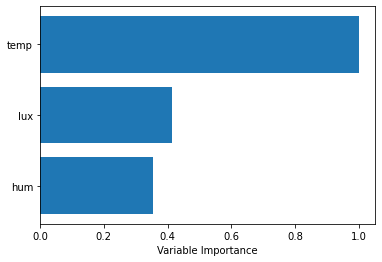

In [779]:
features = np.array(['temp', 'hum', 'lux'])

X_train, X_test, y_train, y_test = train_test_split(feature_tmp,survey_mean,test_size=0.2)

RFModel = RandomForestRegressor(n_estimators=100,
                                max_features=3,
                            oob_score=False,random_state=531)
RFModel.fit(X_train, y_train.ravel())
prediction = RFModel.predict(X_test)

mse = mean_squared_error(y_test,prediction)

feature_importance = RFModel.feature_importances_
if len(set(feature_importance)) == 1:
    feature_importance = RFModel.feature_importances_
else:    
    feature_importance = feature_importance / feature_importance.max()

print(RFModel.feature_importances_)
print(feature_importance)
sorted_idx = np.argsort(feature_importance)
print(sorted_idx[::-1])
bar_pos = np.arange(sorted_idx.shape[0]) + .5

_features = features[sorted_idx]

print(_features)
print(mse)
plt.barh(bar_pos, feature_importance[sorted_idx], align='center')
plt.yticks(bar_pos, _features)
plt.xlabel("Variable Importance")
plt.show()

In [780]:
new_survey = pd.DataFrame(columns=['실제 설문 점수 (평균)', '예측 설문 점수', '오차'])

for days in range(0, 500):
    now_after = now + dt.timedelta(days=days)
    str_after = dt.datetime.strftime(now_after, '%Y-%m-%d')
    
    # 온도 10~32
    ran_temp = ran.randrange(10, 33)
    
    # 습도 30 ~ 80
    ran_hum = ran.randrange(30, 81)
    
    # 조도 200 ~ 1900 (100 단위)
    ran_lux = ran.randrange(200, 1901, 100)
    
    
    np_features = np.array([[ran_temp / max_temp,
                             ran_hum / max_hum, 
                             ran_lux / max_lux]])
    user_scores = np.array([])
    for user_idx in range(0,50):
        _s = users[user_idx].score(ran_temp,
                       ran_hum,
                       ran_lux)
        user_scores = np.append(user_scores,
                               _s)
    
    new_survey.loc[days] = [
        user_scores.mean(),
        RFModel.predict(np_features)[0],
        abs(user_scores.mean() - RFModel.predict(np_features)[0])
    ]

In [781]:
print("해당 모델의 오차 평균은 {}점 입니다.".format(round(new_survey['오차'].mean() * 1000) / 1000))

해당 모델의 오차 평균은 0.32점 입니다.


In [782]:
max_score = y_train[y_train.argmax()]
min_score = y_train[y_train.argmin()]

print("설문점수 중 가장 높은 점수는 {}점 이었으며,\n".format(max_score) \
     + "가장 낮은 점수는 {}점 이었습니다.".format(min_score))

설문점수 중 가장 높은 점수는 55.62점 이었으며,
가장 낮은 점수는 48.32점 이었습니다.


In [783]:
for test in [[X_train[y_train.argmax()]]]:
    pre = RFModel.predict(test)[0]
    
    user_scores = np.array([])
    for user_idx in range(0,50):
        _s = users[user_idx].score(ran_temp,
                       ran_hum,
                       ran_lux)
        user_scores = np.append(user_scores,
                               _s)
        
    print(user_scores.mean())

51.08


In [784]:
new_survey = pd.DataFrame(columns=['온도','습도','조도','실제 설문 점수 (평균)', '예측 설문 점수', '오차'])

for days in range(0, 500):
    now_after = now + dt.timedelta(days=days)
    str_after = dt.datetime.strftime(now_after, '%Y-%m-%d')
    
    # 온도 10~32
    ran_temp = ran.randrange(10, 33)
    
    # 습도 30 ~ 80
    ran_hum = ran.randrange(30, 81)
    
    # 조도 200 ~ 1900 (100 단위)
    ran_lux = ran.randrange(200, 1901, 100)
    
    
    np_features = np.array([[ran_temp / max_temp,
                             ran_hum / max_hum, 
                             ran_lux / max_lux]])
    user_scores = np.array([])
    for user_idx in range(0,50):
        _s = users[user_idx].score(ran_temp,
                       ran_hum,
                       ran_lux)
        user_scores = np.append(user_scores,
                               _s)
    
    new_survey.loc[days] = [
        ran_temp,
        ran_hum,
        ran_lux,
        user_scores.mean(),
        RFModel.predict(np_features)[0],
        abs(user_scores.mean() - RFModel.predict(np_features)[0])
    ]

In [785]:
temp_move_mean = pd.DataFrame(columns=["온도", "예측 설문 점수"])

for temp in range(10, 30):
    static_hum = 0
    static_lux = 0
    
    np_features = np.array([[temp / max_temp,
                           static_hum / max_hum,
                           static_lux / max_lux]])
    temp_move_mean = temp_move_mean.append({
        "온도": temp,
        "예측 설문 점수": RFModel.predict(np_features)[0]
    }, ignore_index=True)
    
temp_move_mean_chk = pd.DataFrame(columns=['이동평균사이즈','최소 온도', '최대 온도', '이동평균'])
    
for w_size in range(3, round(len(temp_move_mean))):
    move_mean = temp_move_mean['예측 설문 점수'].rolling(window=w_size).mean()
    max_idx = move_mean.argmax()
    min_idx = max_idx - (w_size - 1)
    
    move_min_temp = temp_move_mean.iloc[min_idx]['온도']
    move_max_temp = temp_move_mean.iloc[max_idx]['온도']
    
    temp_move_mean_chk = temp_move_mean_chk.append({
        "이동평균사이즈": w_size,
        "최소 온도": move_min_temp,
        "최대 온도": move_max_temp,
        "이동평균": move_mean[max_idx]
    }, ignore_index=True)

s_tmmc = temp_move_mean_chk.sort_values(by=['이동평균'], ascending=False).copy()
temp_move_mean_chk

,이동평균사이즈,최소 온도,최대 온도,이동평균
0,3.0,18.0,20.0,52.335933
1,4.0,18.0,21.0,52.322350
2,5.0,17.0,21.0,52.307680
3,6.0,16.0,21.0,52.256900
4,7.0,15.0,21.0,52.219457
5,8.0,14.0,21.0,52.191225
6,9.0,13.0,21.0,52.176289
7,10.0,13.0,22.0,52.133740
8,11.0,13.0,23.0,52.100982
9,12.0,13.0,24.0,52.085350


In [786]:
hum_move_mean = pd.DataFrame(columns=["습도", "예측 설문 점수"])

for hum in range(30, 81):
    static_temp = 0
    static_lux = 0
    
    np_features = np.array([[static_temp / max_temp,
                           hum / max_hum,
                           static_lux / max_lux]])
    hum_move_mean = hum_move_mean.append({
        "습도": hum,
        "예측 설문 점수": RFModel.predict(np_features)[0]
    }, ignore_index=True)
    
hum_move_mean_chk = pd.DataFrame(columns=['이동평균사이즈','최소 습도', '최대 습도', '이동평균'])

for w_size in range(3, round(len(hum_move_mean))):
    move_mean = hum_move_mean['예측 설문 점수'].rolling(window=w_size).mean()
    max_idx = move_mean.argmax()
    min_idx = max_idx - (w_size - 1)
    
    move_min_hum = hum_move_mean.iloc[min_idx]['습도']
    move_max_hum = hum_move_mean.iloc[max_idx]['습도']
    
    hum_move_mean_chk = hum_move_mean_chk.append({
        "이동평균사이즈": w_size,
        "최소 습도": move_min_hum,
        "최대 습도": move_max_hum,
        "이동평균": move_mean[max_idx]
    }, ignore_index=True)
    
s_hmmc = hum_move_mean_chk.sort_values(by=['이동평균'], ascending=False).copy()    
hum_move_mean_chk

,이동평균사이즈,최소 습도,최대 습도,이동평균
0,3.0,52.0,54.0,51.459133
1,4.0,52.0,55.0,51.453000
2,5.0,52.0,56.0,51.451320
3,6.0,52.0,57.0,51.449600
4,7.0,52.0,58.0,51.446800
5,8.0,52.0,59.0,51.444700
6,9.0,52.0,60.0,51.443067
7,10.0,52.0,61.0,51.441760
8,11.0,51.0,61.0,51.439600
9,12.0,50.0,61.0,51.437800


In [787]:
lux_move_mean = pd.DataFrame(columns=["조도", "예측 설문 점수"])

for lux in range(200, 2000, 100):
    static_temp = 0
    static_hum = 0
    
    np_features = np.array([[static_temp / max_temp,
                           static_hum / max_hum,
                           lux / max_lux]])
    lux_move_mean = lux_move_mean.append({
        "조도": lux,
        "예측 설문 점수": RFModel.predict(np_features)[0]
    }, ignore_index=True)
    
lux_move_mean_chk = pd.DataFrame(columns=['이동평균사이즈','최소 조도', '최대 조도', '이동평균'])

for w_size in range(3, round(len(lux_move_mean))):
    move_mean = lux_move_mean['예측 설문 점수'].rolling(window=w_size).mean()
    max_idx = move_mean.argmax()
    min_idx = max_idx - (w_size - 1)
    
    move_min_lux = lux_move_mean.iloc[min_idx]['조도']
    move_max_lux = lux_move_mean.iloc[max_idx]['조도']
    
    lux_move_mean_chk = lux_move_mean_chk.append({
        "이동평균사이즈": w_size,
        "최소 조도": move_min_lux,
        "최대 조도": move_max_lux,
        "이동평균": move_mean[max_idx]
    }, ignore_index=True)
    
s_lmmc = lux_move_mean_chk.sort_values(by=['이동평균'], ascending=False).copy()
lux_move_mean_chk

,이동평균사이즈,최소 조도,최대 조도,이동평균
0,3.0,800.0,1000.0,52.420933
1,4.0,800.0,1100.0,52.400250
2,5.0,700.0,1100.0,52.383200
3,6.0,700.0,1200.0,52.367500
4,7.0,700.0,1300.0,52.354943
5,8.0,800.0,1500.0,52.347275
6,9.0,800.0,1600.0,52.348822
7,10.0,800.0,1700.0,52.345580
8,11.0,700.0,1700.0,52.342800
9,12.0,600.0,1700.0,52.323650


In [788]:
prefer_features = [
    [
        s_tmmc.iloc[0]['최소 온도'], s_tmmc.iloc[0]['최대 온도']
    ],
    [
        s_hmmc.iloc[0]['최소 습도'], s_hmmc.iloc[0]['최대 습도']
    ],
    [
        s_lmmc.iloc[0]['최소 조도'], s_lmmc.iloc[0]['최대 조도']
    ]
]

print("사용자들이 가장 선호하는 특징별 구간은 아래와 같습니다.")
print("온도 : {} ~ {}".format(prefer_features[0][0],prefer_features[0][1]))
print("습도 : {} ~ {}".format(prefer_features[1][0],prefer_features[1][1]))
print("조도 : {} ~ {}".format(prefer_features[2][0],prefer_features[2][1]))

사용자들이 가장 선호하는 특징별 구간은 아래와 같습니다.
온도 : 18.0 ~ 20.0
습도 : 52.0 ~ 54.0
조도 : 800.0 ~ 1000.0


In [789]:
temp_range = range(
    int(prefer_features[0][0]), int(prefer_features[0][1] + 1)
)
hum_range = range(
    int(prefer_features[1][0]), int(prefer_features[1][1] + 1)
)
lux_range = range(
    int(prefer_features[2][0]), int(prefer_features[2][1] + 1), 50
)

combinations = np.array([])
for _temp in temp_range:
    for _hum in hum_range:
        for _lux in lux_range:
            combinations = np.append(
                combinations,
                [_temp, _hum, _lux]
            )

In [790]:
last_test = pd.DataFrame(columns=['온도', '습도', '조도', '실제 설문조사 평균값','예측값'])

for _temp, _hum, _lux in combinations.reshape(-1, 3):
    np_features = np.array([[
        _temp / max_temp,
        _hum / max_hum,
        _lux / max_lux
    ]])
    pre = RFModel.predict(np_features)[0]
    
    user_scores = np.array([])
    for user_idx in range(0,50):
        _s = users[user_idx].score(ran_temp,
                       ran_hum,
                       ran_lux)
        user_scores = np.append(user_scores,
                               _s)
    
    last_test = last_test.append({
        "온도": _temp,
        "습도": _hum,
        "조도": _lux,
        "실제 설문조사 평균값": user_scores.mean(),
        "예측값": pre
    }, ignore_index=True)

In [791]:
last_test.sort_values(by=['예측값'], ascending=False)

,온도,습도,조도,실제 설문조사 평균값,예측값
4,18.0,52.0,1000.0,52.56,55.1102
14,18.0,54.0,1000.0,52.42,55.0708
9,18.0,53.0,1000.0,52.18,55.0674
3,18.0,52.0,950.0,52.44,55.0626
2,18.0,52.0,900.0,52.46,55.0528
13,18.0,54.0,950.0,52.48,55.0438
8,18.0,53.0,950.0,52.30,55.0382
12,18.0,54.0,900.0,52.52,55.0324
7,18.0,53.0,900.0,52.38,55.0268
19,19.0,52.0,1000.0,52.28,55.0254


In [798]:
print("선호 구간의 평균과 모델 예측값의 오차는 평균 {}점 입니다.".format(
    round(abs((last_test['실제 설문조사 평균값'] - last_test["예측값"]).mean()) * 1000) / 1000
))

선호 구간의 평균과 모델 예측값의 오차는 평균 2.605점 입니다.


In [ ]:
import tensorflow as tf

from tensorflow import feature_column
from tensorflow.keras import layers

from tensorflow import feature_column

df = pd.DataFrame() 

df['temp'] = feature_tmp[:,0].astype("float")
df['hum'] = feature_tmp[:,1].astype("float")
df['lux'] = feature_tmp[:,2].astype("float")
df['score'] = survey_mean.astype("float")

train_dataset = df.sample(frac=0.8,random_state=0)
test_dataset = df.drop(train_dataset.index)

train_labels = train_dataset.pop('score')
test_labels = test_dataset.pop('score')

def build_model():
    model = tf.keras.Sequential([
        layers.Dense(64, activation='relu', input_shape=[len(train_dataset.keys())]),
        layers.Dense(64, activation='relu'),
        layers.Dense(1)
    ])

    optimizer = tf.keras.optimizers.RMSprop(0.001)

    model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
    return model

model = build_model()

# 에포크가 끝날 때마다 점(.)을 출력해 훈련 진행 과정을 표시합니다
class PrintDot(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: 
            print('.', end='')

EPOCHS = 1000

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(
  train_dataset, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[early_stop, PrintDot()])